In [1]:
from __future__ import print_function

In [29]:
import notebook
import warnings

#notebook.nbextensions.check_nbextension("usability/python-markdown/", user = True)
E = notebook.nbextensions.EnableNBExtensionApp()
E.enable_nbextension("usability/python-markdown/main")
warnings.filterwarnings('ignore')

In [3]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

#Machine Learning Engineer Nanodegree

##Project 5: Capstone Project

###Introduction

This documents presents results for the fifth project within the Machine Learning Engineer Nanodegree program. This assessment required the student to leverage exploratory analysis and machine learning techniques in order to understand a problem of their choice. For this assessment, I have chosen to analyze data from the MotoGP (<a href = "https://en.wikipedia.org/wiki/Grand_Prix_motorcycle_racing">wikipedia</a>) 2014 season, and to ultimately build a model which is capable of predicting winning riders.

###Data

This analysis makes use of a variety of datasets relevant to the MotoGP 2014 season. Data was scraped from a variety of web sources and is spread over four tables:

- Session data (session): Data which describes each of the MotoGP 2014 sessions, including the track name, country in which the track is located, track length, and climate statistics.

- Qualifying results (qresult): Results from free practice, warm-up and qualifying sessions, including the riders qualifying place, best time, and top speed, for each of the MotoGP 2014 sessions.

- Race results (rresult): Results from each race, including the riders finishing place, best time, and top speed, for each of the MotoGP 2014 sessions.

- Rider data (rider): Data which describes each of the riders who participated over the MotoGP 2014 season, including the riders name, nationality, bike manufacturer, and team.

Headline statistics for each of these datasets are shown below.

In [4]:
import pandas as pd
import itertools, pandas.io.sql, sqlite3

df_session = pd.read_csv("data/session.csv", sep="\t", encoding="utf-8")
df_qresult = pd.read_csv("data/qresult.csv", sep="\t", encoding="utf-8")
df_rresult = pd.read_csv("data/rresult.csv", sep="\t", encoding="utf-8")
df_rider = pd.read_csv("data/rider.csv", sep="\t", encoding="utf-8")

conn = sqlite3.connect("data/motogp.db")

list_df = [df_session, df_qresult, df_rresult, df_rider]
list_tbl = ["session", "qresult", "rresult", "rider"]

for d, t in zip(list_df, list_tbl):
    dropQuery = "DROP TABLE IF EXISTS " + str(t)
    conn.execute(dropQuery).fetchone()
    pandas.io.sql.to_sql(d, t, conn)
    selQuery = "SELECT * FROM " + str(t)
    conn.execute(selQuery).fetchone()
    
conn.close()

In [5]:
import pandas, sqlite3

conn = sqlite3.connect("data/motogp.db")
curs = conn.cursor()  

d_session2014motogp = "DROP TABLE IF EXISTS session2014motogp"
d_qresult2014motogp = "DROP TABLE IF EXISTS qresult2014motogp"
d_rresult2014motogp = "DROP TABLE IF EXISTS rresult2014motogp"
d_rider2014motogp = "DROP TABLE IF EXISTS rider2014motogp"

temp = conn.execute(d_session2014motogp)
temp = conn.execute(d_qresult2014motogp)
temp = conn.execute(d_rresult2014motogp)
temp = conn.execute(d_rider2014motogp)

tblQuery = "SELECT name FROM sqlite_master WHERE type = 'table' ORDER BY Name"
curs.execute(tblQuery)
tables = map(lambda t: t[0], curs.fetchall())

totalColumns, totalRows, totalCells = 0, 0, 0
resultcols = ["Table Name", "Column Count", "Row (Record) Count", "Cell Count"]

results_df = pd.DataFrame([])

for table in tables:
    columnsQuery = "PRAGMA table_info(%s)" % table
    curs.execute(columnsQuery)
    numberOfColumns = len(curs.fetchall())
    rowsQuery = "SELECT Count() FROM %s" % table
    curs.execute(rowsQuery)
    numberOfRows = curs.fetchone()[0]
    numberOfCells = numberOfColumns * numberOfRows
    temp_df = pandas.DataFrame([[table, 
                                 numberOfColumns, 
                                 numberOfRows, 
                                 numberOfCells]], columns=resultcols)
    results_df = results_df.append(temp_df)

curs.close()
conn.close()

print("Table 1: Headline Dataset Statistics Table")
results_df.reset_index().drop("index", 1)

Table 1: Headline Dataset Statistics Table


,Table Name,Column Count,Row (Record) Count,Cell Count
0,qresult,9,82791,745119
1,rider,8,2933,23464
2,rresult,7,16728,117096
3,session,14,3790,53060


In [6]:
import pandas, sqlite3

conn = sqlite3.connect("data/motogp.db")
curs = conn.cursor()

c_session2014motogp = """
CREATE TABLE session2014motogp AS
SELECT * FROM session
WHERE (
session.sessionSeason = 2014 AND
session.sessionClass = "MotoGP"
)
"""

c_qresult2014motogp = """
CREATE TABLE qresult2014motogp AS
SELECT * FROM qresult
WHERE qresult.sessionId IN ( 
SELECT session2014motogp.sessionId FROM session2014motogp 
)
"""

c_rresult2014motogp = """
CREATE TABLE rresult2014motogp AS
SELECT * FROM rresult
WHERE rresult.sessionId IN ( 
SELECT session2014motogp.sessionId FROM session2014motogp 
)
"""

c_rider2014motogp = """
CREATE TABLE rider2014motogp AS
SELECT * FROM rider
WHERE rider.riderId IN ( 
SELECT qresult2014motogp.riderId FROM qresult2014motogp
) OR rider.riderId IN (
SELECT rresult2014motogp.riderId FROM rresult2014motogp
)
"""

temp = conn.execute(c_session2014motogp)
temp = conn.execute(c_qresult2014motogp)
temp = conn.execute(c_rresult2014motogp)
temp = conn.execute(c_rider2014motogp)
    
df_session2014motogp = pandas.io.sql.read_sql("SELECT * FROM session2014motogp", conn)
#df_session2014motogp = df_session2014motogp.drop(["index"], 1)

df_qresult2014motogp = pandas.io.sql.read_sql("SELECT * FROM qresult2014motogp", conn)
#df_qresult2014motogp = df_session2014motogp.drop(["index"], 1)

df_rresult2014motogp = pandas.io.sql.read_sql("SELECT * FROM rresult2014motogp", conn)
#df_rresult2014motogp = df_session2014motogp.drop(["index"], 1)
    
df_rider2014motogp = pandas.io.sql.read_sql("SELECT * FROM rider2014motogp", conn)
#df_rider2014motogp = df_session2014motogp.drop(["index"], 1)
    
curs.close()
conn.close()

A summary table of the list of columns for each dataset is shown below.

In [7]:
list_datasummary = [df_session2014motogp.columns,
                    df_qresult2014motogp.columns,
                    df_rresult2014motogp.columns,
                    df_rider2014motogp.columns]

df_datasummary = pd.DataFrame(list_datasummary).T
df_datasummary.columns = ["session", "qresult", "rresult", "rider"]

print("Table 2: Dataset Columns")
df_datasummary[2:]

Table 2: Dataset Columns


,session,qresult,rresult,rider
2,sessionId,sessionId,sessionId,riderId
3,sessionSeason,riderId,riderId,riderName
4,sessionCountry,qresultPlace,rresultPlace,riderNumber
5,sessionTrackname,qresultBesttime,rresultTotaltime,riderNationality
6,sessionClass,qresultBestlap,rresultTopspeed,riderTeam
7,sessionSession,qresultTotallap,None,riderMotortype
8,sessionDate,qresultTopspeed,None,None
9,sessionTracklength,None,None,None
10,sessionWeathertype,None,None,None
11,sessionAirtemp,None,None,None


###Exploratory Analysis

The table below shows counts of key variables contained within the datasets.

In [8]:
ntracks = len(df_session2014motogp["sessionTrackname"].unique())
nsession = len(df_session2014motogp["sessionSession"].unique())
nrider = len(df_rider2014motogp["riderId"].unique())
nteam = len(df_rider2014motogp["riderTeam"].unique())
nmotor = len(df_rider2014motogp["riderMotortype"].unique())

list_datastats = [["Number of tracks", 
                   "Sessions at each track", 
                   "Number of riders", 
                   "Number of teams", 
                   "Number of manufacturers"],
                  [ntracks, nsession, nrider, nteam, nmotor]]

df_datastats = pd.DataFrame(list_datastats).T
df_datastats = df_datastats.set_index(0)
df_datastats.index.name = None
df_datastats.columns = ["Count"]

print("Table 3: Count of Key Variables")
df_datastats

Table 3: Count of Key Variables


,Count
Number of tracks,18
Sessions at each track,8
Number of riders,31
Number of teams,17
Number of manufacturers,8


####Session Data

The 'session' dataframe contains track length data for each track within the MotoGP 2014 season. 

In [9]:
df_session2014motogprace = df_session2014motogp[df_session2014motogp["sessionSession"] == "RAC"]

mintracklength = df_session2014motogprace["sessionTracklength"].min()
maxtracklength = df_session2014motogprace["sessionTracklength"].max()
meantracklength = df_session2014motogprace["sessionTracklength"].mean()

minlengthtrackname = df_session2014motogprace.loc[df_session2014motogprace["sessionTracklength"] == mintracklength]["sessionTrackname"].values[0]
maxlengthtrackname = df_session2014motogprace.loc[df_session2014motogprace["sessionTracklength"] == maxtracklength]["sessionTrackname"].values[0]

print("Shortest track (meters):", minlengthtrackname, mintracklength)
print("Longest track (meters):", maxlengthtrackname, maxtracklength)
print("Average track length (meters):", meantracklength)

Shortest track (meters): Sachsenring 3671.0
Longest track (meters): Silverstone Circuit 5900.0
Average track length (meters): 4781.444444444444


As seen in the chart below, there is a large variation in length over each track, with the longest track, Silverstone, being over two kilometres longer than the shortest track, Sachsenring. It is worth noting that tracks with sweeping corners and longer straights may benefit bike manufacturers which have a top speed advantage, while tighter tracks with shorter straights may benefit bike manufacturers which have an advantage under breaking and acceleration. 

Figure 1: Track Length Comparison


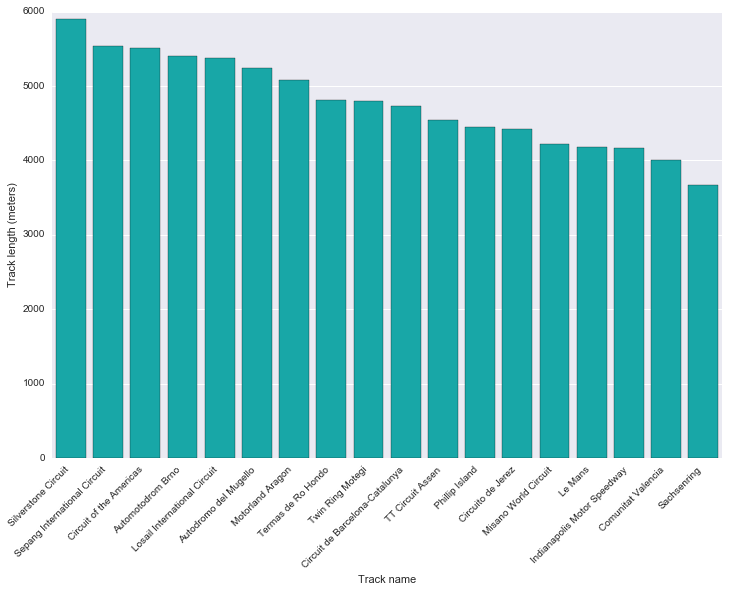

In [10]:
#!pip install seaborn
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

df_temp = df_session2014motogprace.sort_values(by="sessionTracklength", ascending=False)

fig = plt.subplots(figsize=(12, 8))
ax = sns.barplot(x="sessionTrackname", y="sessionTracklength", data=df_temp, color="c")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

#ax.set_title("Figure 1: Track Length Comparison")
ax.set_ylabel("Track length (meters)")
ax.set_xlabel("Track name")

print("Figure 1: Track Length Comparison")
plt.show()

We can observe that longer tracks do generally allow for greater maximum speed by plotting the maximum speed each rider achieved over each race session against track length.

Figure 2: Top Speed vs. Track Length


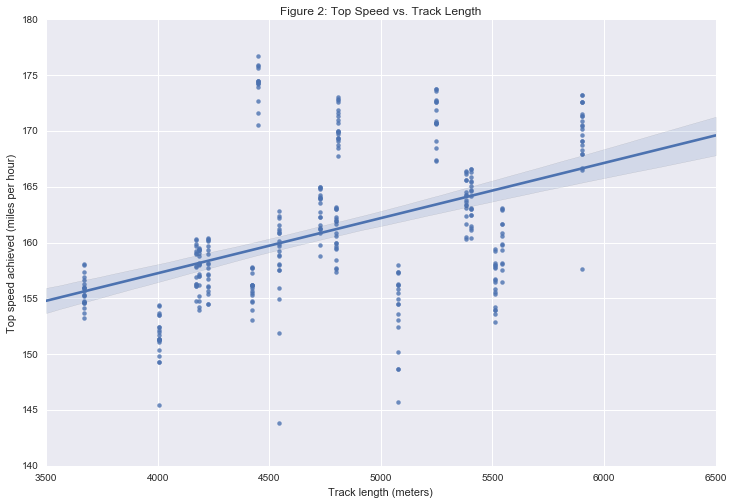

In [11]:
#!pip install seaborn
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

dict_sessionidtracklength = df_session2014motogp.set_index("sessionId")["sessionTracklength"].to_dict()
df_temp = df_rresult2014motogp[["sessionId", "rresultTopspeed"]].replace({"sessionId": dict_sessionidtracklength})
df_temp.columns = ["sessionTracklength", "rresultTopspeed"]

fig, ax = plt.subplots(figsize=(12, 8))
sns.regplot(x="sessionTracklength", y="rresultTopspeed", data=df_temp)
ax.set_title("Figure 2: Top Speed vs. Track Length")
ax.set_ylabel("Top speed achieved (miles per hour)")
ax.set_xlabel("Track length (meters)")

print("Figure 2: Top Speed vs. Track Length")
plt.show()

The 'session' dataframe also contains climate data for each session of the MotoGP 2014 season. 

In [12]:
df_session2014motogprace = df_session2014motogp[df_session2014motogp["sessionSession"] == "RAC"]

mintrackairtemp = df_session2014motogprace["sessionAirtemp"].min()
maxtrackairtemp = df_session2014motogprace["sessionAirtemp"].max()
meantrackairtemp = df_session2014motogprace["sessionAirtemp"].mean()

minairtemptrackname = df_session2014motogprace.loc[df_session2014motogprace["sessionAirtemp"] == mintrackairtemp]["sessionTrackname"].values[0]
maxairtemptrackname = df_session2014motogprace.loc[df_session2014motogprace["sessionAirtemp"] == maxtrackairtemp]["sessionTrackname"].values[0]

print("Lowest air temperature over race session (degrees celsius):", minairtemptrackname, mintrackairtemp)
print("Highest air temperature over race session (degrees celsius):", maxairtemptrackname, maxtrackairtemp)
print("Average air temperature (degrees celsius):", meantrackairtemp)

Lowest air temperature over race session (degrees celsius): Phillip Island 16.0
Highest air temperature over race session (degrees celsius): Sepang International Circuit 36.0
Average air temperature (degrees celsius): 22.5


Sepang reported by far the greatest air temperature for race sessions over all tracks, while Phillip Island reported the lowest. As with track length, some bike manufacturers and riders may have an advantage when riding under certain weather conditions. 

Figure 3: Track Air Temperature Comparison


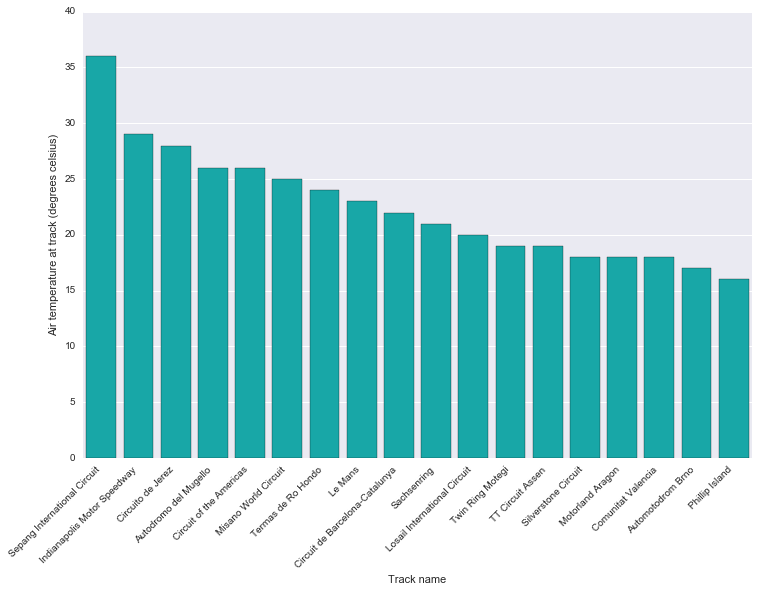

In [13]:
#!pip install seaborn
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

df_temp = df_session2014motogprace.sort_values(by="sessionAirtemp", ascending=False)

fig = plt.subplots(figsize=(12, 8))
ax = sns.barplot(x="sessionTrackname", y="sessionAirtemp", data=df_temp, color="c")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

#ax.set_title("Figure 3: Track Air Temperature Comparison")
ax.set_ylabel("Air temperature at track (degrees celsius)")
ax.set_xlabel("Track name")

print("Figure 3: Track Air Temperature Comparison")
plt.show()

Weather conditions at each session are also categorized under four different types depending on rainfall, these include 'dry', 'wet', 'wet-dry' and 'dry-wet'. A 'wet-dry' label indicates that the session started with rainfall which stopped at some later point during the same session, while a 'dry-wet' label indicates that the session started dry but had rain at some later point during the same session.

In [14]:
print("Number of 'dry' sessions:", df_session2014motogp.groupby("sessionWeathertype")["sessionWeathertype"].count()["Dry"])
print("Number of 'wet' sessions:", df_session2014motogp.groupby("sessionWeathertype")["sessionWeathertype"].count()["Wet"])
print("Number of 'wet-dry' sessions:", df_session2014motogp.groupby("sessionWeathertype")["sessionWeathertype"].count()["Wet-Dry"])

Number of 'dry' sessions: 135
Number of 'wet' sessions: 8
Number of 'wet-dry' sessions: 1


We can also observe the number of classified weather sessions for each track.

In [15]:
#df_session2014motogp.groupby(["sessionTrackname", "sessionWeathertype"])["sessionTrackname"].count()
df_session2014motogp.groupby(["sessionTrackname", "sessionWeathertype"]).size()

sessionTrackname                sessionWeathertype
Autodromo del Mugello           Dry                   7
                                Wet                   1
Automotodrom Brno               Dry                   7
                                Wet                   1
Circuit de Barcelona-Catalunya  Dry                   8
Circuit of the Americas         Dry                   8
Circuito de Jerez               Dry                   8
Comunitat Valencia              Dry                   8
Indianapolis Motor Speedway     Dry                   8
Le Mans                         Dry                   8
Losail International Circuit    Dry                   8
Misano World Circuit            Dry                   6
                                Wet                   2
Motorland Aragon                Dry                   7
                                Wet                   1
Phillip Island                  Dry                   8
Sachsenring                     Dry                  

####Rider Results

As mentioned earlier, there were eight sessions held at each track over the MotoGP 2014 season. These sessions included four free practice sessions (FP1, FP2, FP3, FP4), two qualifying sessions (Q1, Q2), a warm-up session (WUP) and a race session (RAC). Sessions were held in this order. Free practice sessions are intended to provide teams with an opportunity to test and optimize their bike setup to suit the track, qualifying sessions are held in order to determine the starting grid order, and finally, a warm-up session is held just before the race for each team to determine whether any final adjustments need to be made.

One common observation made over free practice sessions, is that riders generally improve their times over each session. Those riders who are able to find optimal bike settings the fastest, go on to improve their practice times and generally go on as favourites for qualifying sessions. The box and whisker plot below is intended to demonstrate this observation, by plotting the best lap time for each rider over each free practice session for Phillip Island.

Figure 4: Best Times over Free Practice Sessions for Phillip Island


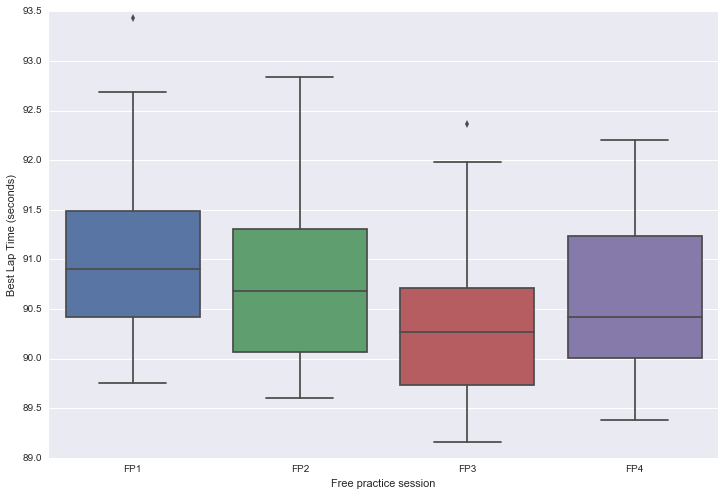

In [16]:
#!pip install seaborn
import re
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

def convertdatetime(dt):
    f = "%Y-%m-%d %H:%M:%S.%f"
    r = re.compile(f)
    if dt == "nan" or r.match(dt) is not None:
        return np.NaN
    else:
        a = datetime.strptime(dt, f)
        b = datetime(1900, 1, 1)   
        return (a-b).total_seconds()


df_session2014motogpfpfp1 = df_session2014motogp[(df_session2014motogp["sessionTrackname"] == "Phillip Island") & (df_session2014motogp["sessionSession"] == "FP1")]
df_session2014motogpfpfp2 = df_session2014motogp[(df_session2014motogp["sessionTrackname"] == "Phillip Island") & (df_session2014motogp["sessionSession"] == "FP2")]
df_session2014motogpfpfp3 = df_session2014motogp[(df_session2014motogp["sessionTrackname"] == "Phillip Island") & (df_session2014motogp["sessionSession"] == "FP3")]
df_session2014motogpfpfp4 = df_session2014motogp[(df_session2014motogp["sessionTrackname"] == "Phillip Island") & (df_session2014motogp["sessionSession"] == "FP4")]

df_qresult2014motogpfpfp1 = df_qresult2014motogp[df_qresult2014motogp["sessionId"].isin(df_session2014motogpfpfp1["sessionId"])]
df_qresult2014motogpfpfp2 = df_qresult2014motogp[df_qresult2014motogp["sessionId"].isin(df_session2014motogpfpfp2["sessionId"])]
df_qresult2014motogpfpfp3 = df_qresult2014motogp[df_qresult2014motogp["sessionId"].isin(df_session2014motogpfpfp3["sessionId"])]
df_qresult2014motogpfpfp4 = df_qresult2014motogp[df_qresult2014motogp["sessionId"].isin(df_session2014motogpfpfp4["sessionId"])]

df_qresult2014motogpfpfp1 = df_qresult2014motogpfpfp1[["riderId", "sessionId", "qresultBesttime"]]
df_qresult2014motogpfpfp2 = df_qresult2014motogpfpfp2[["riderId", "sessionId", "qresultBesttime"]]
df_qresult2014motogpfpfp3 = df_qresult2014motogpfpfp3[["riderId", "sessionId", "qresultBesttime"]]
df_qresult2014motogpfpfp4 = df_qresult2014motogpfpfp4[["riderId", "sessionId", "qresultBesttime"]]

df_qresult2014motogpfpfp1 = df_qresult2014motogpfpfp1.set_index("riderId")
df_qresult2014motogpfpfp2 = df_qresult2014motogpfpfp2.set_index("riderId")
df_qresult2014motogpfpfp3 = df_qresult2014motogpfpfp3.set_index("riderId")
df_qresult2014motogpfpfp4 = df_qresult2014motogpfpfp4.set_index("riderId")

df_temp = pd.concat([df_qresult2014motogpfpfp1, 
                     df_qresult2014motogpfpfp2,
                     df_qresult2014motogpfpfp3,
                     df_qresult2014motogpfpfp4], axis=0)

dict_sessionidsession = df_session2014motogp.set_index("sessionId")["sessionSession"].to_dict()
df_temp.columns = ["sessionId", "qresultBesttime"]
df_temp = df_temp[["sessionId", "qresultBesttime"]].replace({"sessionId": dict_sessionidsession})

df_temp["qresultBesttime"] = df_temp.apply(lambda row: convertdatetime(row[1]), axis=1)

fig, ax = plt.subplots(figsize=(12, 8))
sns.boxplot(x="sessionId", y="qresultBesttime", data=df_temp)
#ax.set_title("Figure 4: Best Times over Free Practice Sessions for Phillip Island")
ax.set_ylabel("Best Lap Time (seconds)")
ax.set_xlabel("Free practice session")

print("Figure 4: Best Times over Free Practice Sessions for Phillip Island")
plt.show()

Interestingly, this trend held over the first three free practice sessions at Phillip Island, however there was a drop off in lap times set over the final session. One explanation is that, due to rules over the MotoGP 2014 season, teams needed to consider tyre allocations over not just the free practice sessions, but also qualifying sessions. That is, each team is only given a certain allocation of tyres, and the riders may have spent the good part of their tyre allocation in the lead up to the third practice session with a new set of tyres in reserve for qualifying.

Final results for each race session over the MotoGP 2014 season are shown in the table below. Note that a 'DNF' indicates that the rider failed to finish the race.

In [17]:
import pandas as pd
import numpy as np

list_rresult2014motogpsessionid = df_rresult2014motogp["sessionId"].unique()
dict_rideridname = df_rider.set_index("riderId")["riderName"].to_dict()

dict_sessionidcountry = df_session2014motogp.set_index("sessionId")["sessionCountry"].to_dict()

df_results = pd.DataFrame([])

for i in list_rresult2014motogpsessionid:
    df_temp = df_rresult2014motogp[df_rresult2014motogp["sessionId"] == i][["riderId", "rresultPlace"]]
    df_temp = df_temp[["riderId", "rresultPlace"]].replace({"riderId": dict_rideridname})
    df_temp = df_temp.set_index("riderId")
    df_temp.columns = [i]
    df_results = pd.concat([df_results, df_temp], axis=1)

df_results = df_results.rename(columns=dict_sessionidcountry)
df_results = df_results.replace(np.nan, "DNF", regex=True)
df_raceresults = df_results

print("Table 4: MotoGP 2014 Race Results")
df_raceresults

Table 4: MotoGP 2014 Race Results


,QAT,AME,ARG,SPA,FRA,ITA,CAT,NED,GER,INP,CZE,GBR,RSM,ARA,JPN,AUS,MAL,VAL
Aleix ESPARGARO,4,9,15,7,9,9,6,4,6,DNF,8,9,DNF,2,11,DNF,DNF,7
Alex DE ANGELIS,DNF,DNF,DNF,DNF,DNF,DNF,DNF,DNF,DNF,DNF,16,15,14,12,17,9,DNF,18
Alvaro BAUTISTA,DNF,DNF,DNF,6,3,8,DNF,7,9,DNF,10,DNF,8,7,10,6,DNF,16
Andrea DOVIZIOSO,5,3,9,5,8,6,8,2,8,7,6,5,4,DNF,5,4,8,4
Andrea IANNONE,10,7,6,DNF,DNF,7,9,6,5,DNF,5,8,5,DNF,6,DNF,DNF,22
Bradley SMITH,DNF,5,7,8,10,DNF,10,8,19,6,9,22,7,5,9,3,5,14
Broc PARKES,15,DNF,21,17,18,17,16,11,21,15,19,21,18,18,20,DNF,14,20
Cal CRUTCHLOW,6,DNF,DNF,DNF,11,DNF,DNF,9,10,8,DNF,12,9,3,DNF,DNF,DNF,5
Colin EDWARDS,9,DNF,20,DNF,17,15,18,22,20,13,DNF,DNF,DNF,DNF,DNF,DNF,DNF,DNF
Dani PEDROSA,3,2,2,3,5,4,3,3,2,4,1,4,3,14,4,DNF,DNF,3


Riders are awarded championship points depending on their final race result. Riders who achieve a first place result are awarded 25 points, a second place result is awarded 20 points, third is awarded 16 points and so forth. More information on the amount of points awarded for each position can be found on the <a href = "http://www.motogp.com">MotoGP website</a>.

The table below shows the final championship points for each rider over the MotoGP 2014 season.

In [18]:
dict_champpoints = {1 : 25, 2 : 20, 3 : 16, 4 : 13, 5 : 11, 6 : 10, 7 : 9, 8 : 8, 9 : 7, 10 : 6, 
                    11 : 5, 12 : 4, 13 : 3, 14 : 2, 15 : 1, 16 : 0, 17 : 0, 18 : 0, 19 : 0, 20 : 0, 
                    21 : 0, 22 : 0, 23 : 0, 24 : 0, 25 : 0, 26 : 0, 27 : 0, 28 : 0, 29 : 0, 30 : 0, 
                    31 : 0, 32 : 0, 33 : 0, 34 : 0, 35 : 0, 36 : 0, 37 : 0, 38 : 0, 39 : 0, 40 : 0}

df_champpoints = df_results
df_champpoints = df_champpoints.replace("DNF", np.nan, regex=True)
df_champpoints = df_champpoints.replace(dict_champpoints)
df_champpoints["Total"] = df_champpoints.sum(axis=1)
df_champpoints = df_champpoints.sort_values(by="Total", ascending=False)
df_champpoints = df_champpoints.replace(np.nan, "DNF", regex=True)

print("Table 5: MotoGP 2014 Championship Points")
df_champpoints

Table 5: MotoGP 2014 Championship Points


,QAT,AME,ARG,SPA,FRA,ITA,CAT,NED,GER,INP,CZE,GBR,RSM,ARA,JPN,AUS,MAL,VAL,Total
Marc MARQUEZ,25,25,25,25,25,25,25,25,25,25,13,25,1,3,20,DNF,25,25,362
Valentino ROSSI,20,8,13,20,20,16,20,11,13,16,16,16,25,DNF,16,25,20,20,295
Jorge LORENZO,DNF,6,16,13,10,20,13,3,16,20,20,20,20,25,25,20,16,DNF,263
Dani PEDROSA,16,20,20,16,11,13,16,16,20,13,25,13,16,2,13,DNF,DNF,16,246
Andrea DOVIZIOSO,11,16,7,11,8,10,8,20,8,9,10,11,13,DNF,11,13,8,13,187
Pol ESPARGARO,DNF,10,8,7,13,11,9,DNF,9,11,DNF,10,10,10,8,DNF,10,10,136
Aleix ESPARGARO,13,7,1,9,7,7,10,13,10,DNF,8,7,DNF,20,5,DNF,DNF,9,126
Bradley SMITH,DNF,11,9,8,6,DNF,6,8,0,10,7,0,9,11,7,16,11,2,121
Stefan BRADL,DNF,13,11,6,9,DNF,11,6,0,DNF,9,9,DNF,13,9,DNF,13,8,117
Andrea IANNONE,6,9,10,DNF,DNF,9,7,10,11,DNF,11,8,11,DNF,10,DNF,DNF,0,102


Below shows a plot of cumulative championship points earnt by each of the final top five riders. Marc Marquez gains a huge lead over the early sessions of the championship scoring back-to-back wins for the first 10 sessions. It isn't until the second half of the season that Jorge Lorenzo and Valentino Rossi are able to start to close the gap on Marc.

Figure 4: Cumulative Championship Point


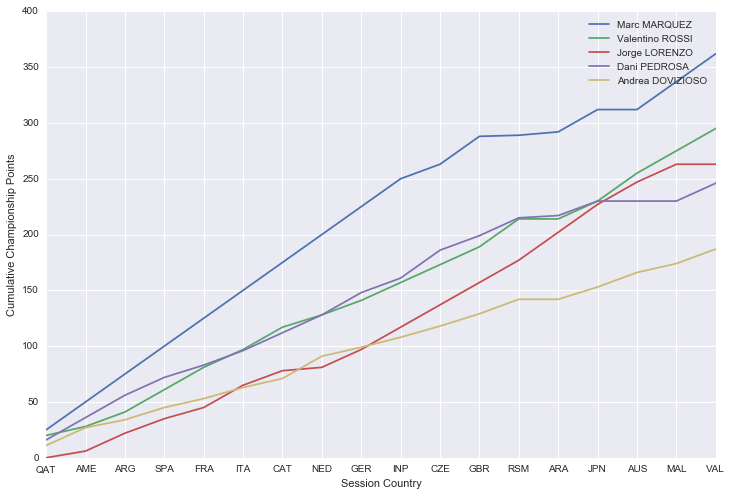

In [19]:
#!pip install seaborn
import matplotlib.pyplot as plt
#import seaborn as sns
%matplotlib inline

df_cumpoints = df_results
df_cumpoints = df_cumpoints.replace("DNF", np.nan, regex=True)
df_cumpoints = df_cumpoints.replace(dict_champpoints)
df_cumpoints = df_cumpoints.replace(np.nan, 0, regex=True)
df_cumpoints = df_cumpoints.cumsum(axis=1)
df_cumpoints["Total"] = df_cumpoints.sum(axis=1)
df_cumpoints = df_cumpoints.sort_values(by="Total", ascending=False)
df_cumpoints = df_cumpoints.drop("Total", 1)
df_cumpoints = df_cumpoints.sort_values(by="VAL", ascending=False)
df_cumpoints

df_temp = df_cumpoints[:5].T
df_temp = df_temp.reset_index()
list_sessionCountry = df_temp["index"].tolist()
df_temp = df_temp.drop("index", 1)

#sns.set_style("darkgrid")
df_temp.plot(figsize=(12, 8))
plt.xticks(np.arange(0, len(df_temp)), list_sessionCountry)
plt.ylabel("Cumulative Championship Points")
plt.xlabel("Session Country")
plt.legend()

print("Figure 4: Cumulative Championship Point")
plt.show()

As mentioned previously, there were two qualifying sessions held at each track over the MotoGP 2014 season. The format of these qualifying sessions are quite unique in motorsport with new rules introduced during the 2013 season. Under the new rules, the top 10 fastest riders over the free practice sessions go straight onto the second qualifying practice session (Q2), while the remaining riders participate in the first qualifying session (Q1). Of those riders who participate in Q1, the top two fastest riders under that session also compete against the 10 fastest riders during Q2. Qualifying results over both sessions are then aggregated to determine the starting grid position for all riders.

The table below shows the aggregated qualifying results for all riders. Note that a 'DNQ' indicates that the rider did not qualify.

In [20]:
import pandas as pd
import numpy as np

def aggregateq1q2(q1, q2, n):
    if q1 > 2:
        return q1 + n
    else:
        return q2


list_session2014motogpqpsessionid = df_session2014motogp[(df_session2014motogp["sessionSession"] == "Q1") | (df_session2014motogp["sessionSession"] == "Q2")]["sessionId"].unique()
dict_rideridname = df_rider.set_index("riderId")["riderName"].to_dict()

dict_sessionidcountry = df_session2014motogp.set_index("sessionId")["sessionCountry"].to_dict()

df_qualresults = pd.DataFrame([])

for i in range(0, len(list_session2014motogpqpsessionid), 2):
    df_tempresults = pd.DataFrame([])
    for j in range(0, 2):
        qindex = list_session2014motogpqpsessionid[i + j]
        df_temp = df_qresult2014motogp[df_qresult2014motogp["sessionId"] == qindex][["riderId", "qresultPlace"]]
        df_temp = df_temp[["riderId", "qresultPlace"]].replace({"riderId": dict_rideridname})
        df_temp = df_temp.set_index("riderId")
        df_temp.columns = [qindex]
        df_tempresults = pd.concat([df_tempresults, df_temp], axis=1)
    n = float(df_tempresults[[qindex]].max().values - 2)
    df_tempresults[qindex] = df_tempresults.apply(lambda row: aggregateq1q2(row[qindex-1], row[qindex], n), axis=1)
    df_tempresults = df_tempresults.drop(qindex-1, 1)
    df_qualresults = pd.concat([df_qualresults, df_tempresults], axis=1)
      
df_qualresults = df_qualresults.rename(columns=dict_sessionidcountry)

df_qualresults = df_qualresults.replace(np.nan, "DNQ", regex=True)

print("Table 6: MotoGP 2014 Aggregated Qualifying Results")
df_qualresults

Table 6: MotoGP 2014 Aggregated Qualifying Results


,QAT,AME,ARG,SPA,FRA,ITA,CAT,NED,GER,INP,CZE,GBR,RSM,ARA,JPN,AUS,MAL,VAL
Aleix ESPARGARO,9,4,4,5,8,12,6,1,4,4,10,4,8,10,11,6,7,11
Alex DE ANGELIS,DNQ,DNQ,DNQ,DNQ,DNQ,DNQ,DNQ,DNQ,DNQ,DNQ,20,17,19,18,20,23,17,19
Alvaro BAUTISTA,2,12,10,10,7,11,12,10,10,14,14,12,12,14,12,17,10,13
Andrea DOVIZIOSO,4,10,5,6,3,8,7,7,11,2,2,2,6,9,1,10,5,9
Andrea IANNONE,11,9,8,15,11,2,11,4,7,7,3,10,2,3,6,7,DNQ,2
Bradley SMITH,3,8,7,9,10,7,8,6,9,9,4,7,9,11,10,4,9,7
Broc PARKES,21,21,18,23,20,22,19,19,22,22,23,23,20,21,24,22,21,24
Cal CRUTCHLOW,8,7,DNQ,14,12,6,13,5,15,12,11,15,13,5,8,2,8,8
Colin EDWARDS,14,19,14,11,15,18,17,18,19,15,DNQ,DNQ,DNQ,DNQ,DNQ,DNQ,DNQ,DNQ
Dani PEDROSA,6,2,3,3,9,4,1,3,2,8,5,5,5,2,3,5,2,3


In [21]:
df_raceresults = df_raceresults.replace("DNF", np.nan, regex=True)
df_qualresults = df_qualresults.replace("DNQ", np.nan, regex=True)

for i in range(0, len(df_raceresults.index)):
    wins = 0
    poles = 0
    for j in range(0, len(df_raceresults.columns)):
        if df_qualresults.values[i,j] == 1 and df_raceresults.values[i,j] != np.nan:
            rider = df_raceresults.iloc[[i]].index.values[0]
            poles += 1
            if df_raceresults.values[i,j] == 1:
                wins += 1
    #if wins > 0:
        #print(rider, wins/poles)

###Building a Prediction Model

####Approach

There are a number of machine learning approaches that could be used to predict the winning rider of a MotoGP race. These approaches can be bucketed under either ranking algorithms, classifiers, or regression approaches. 

A ranking algorithm such as ordinal regression, tries to learn it's ordered rank (i.e. the final position of racers). However, this approach assumes independence over results. That is, it would generate the prediction of a particular rider's result without consideration of riders who have placed higher or lower than that rider. Applying a classification algorithm would also suffer from the same independence assumption, however, there may be scope to use measures of confidence of the prediction generated by the algorithm to rank results. Finally, a regression approach could be used to predict the riders total race time, or time behind the lead rider.

For this assessment, I decided to apply a classification approach to construct a model which predicts only the first place rider of each race rather than the entire final race result. Such an approach is well suited to the non-continuous nature of the majority of the datasets and can be expanded on later to include the use of confidence ranking to include predictions for the full range of rider results.

####Feature Selection

The array below shows the full feature set for consideration.

In [22]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 500)

# Create list of unique race and qualifying ids
list_qresult2014motogpsessionid = df_qresult2014motogp["sessionId"].unique()
list_rresult2014motogpsessionid = df_rresult2014motogp["sessionId"].unique()

#Create dictonary index for session id and race session id
dict_sessionidsession = df_session2014motogp.set_index("sessionId")["sessionSession"].to_dict()

dict_sessionidracsessionid = {}
for i in list_rresult2014motogpsessionid:
    sessioncountry = df_session2014motogp[df_session2014motogp["sessionId"] == i]["sessionCountry"].values[0]
    for j in range(-10, 10):
        if j != 0:
            if len(df_session2014motogp[(df_session2014motogp["sessionId"] == i+j) & \
                                        (df_session2014motogp["sessionCountry"] == sessioncountry)]) == 1:
                dict_sessionidracsessionid[i+j] = i
                
# Create temporary dataframe
df_temp = df_qresult2014motogp

# Add session type and race session id to qresults
df_temp["sessionId2"] = df_temp["sessionId"]
df_temp["sessionId3"] = df_temp["sessionId"]
df_temp = df_temp.replace({"sessionId2": dict_sessionidsession})
df_temp = df_temp.rename(columns={"sessionId2": "sessionSession"})
df_temp = df_temp.replace({"sessionId3": dict_sessionidracsessionid})
df_temp = df_temp.rename(columns={"sessionId3": "racsessionId"})

# Crete new race session id + rider id index
df_temp["racsessionriderId"] = df_temp["racsessionId"].map(str) + "_" + df_temp["riderId"].map(str)
df_temp = df_temp.drop(["index", "Unnamed: 0", "sessionId", "riderId", "racsessionId"], 1)

# Pivot table on new index and to new fields as needed
df_temp = df_temp.pivot(index="racsessionriderId", columns="sessionSession")
df_temp.columns = [str(x) + str(y) for x, y in list(df_temp.columns)]
df_temp = df_temp.reset_index()
df_ids = df_temp.racsessionriderId.str.split("_").apply(pd.Series)
df_ids.columns = ["racsessionId", "riderId"]
df_temp = pd.concat([df_temp, df_ids], axis=1)

# Drop race session id + rider id index
df_temp = df_temp.drop("racsessionriderId", 1)
df_temp = df_temp.rename(columns = {"racsessionId": "sessionId"})
df_temp[["sessionId", "riderId"]] = df_temp[["sessionId", "riderId"]].astype(float)

# Merge race result, rider and session data
df_temp = pd.merge(df_temp, df_rresult2014motogp, on=["riderId", "sessionId"], how="left")
df_temp = pd.merge(df_temp, df_rider2014motogp, on="riderId", how="left")
df_temp = pd.merge(df_temp, df_session2014motogp, on="sessionId", how="left")

# Drop unnecessary and non-feature fields
df_temp = df_temp.drop(["index",
                        "Unnamed: 0",
                        "index_x", 
                        "Unnamed: 0_x", 
                        "index_y", 
                        "Unnamed: 0_y",
                        "riderName",
                        "riderNumber",
                        "rresultTotaltime",
                        "rresultTopspeed",
                        "sessionId",
                        "sessionSeason",
                        "sessionClass",
                        "sessionCountry",
                        "sessionSession",
                        "sessionDate"], 1)

# Convert race result field to boolean
df_temp["rresultPlace"][df_temp["rresultPlace"] > 1] = 0
df_temp["rresultPlace"] = df_temp["rresultPlace"].fillna(0).astype(bool)

# Create label and features dataframe
df_label = pd.DataFrame(df_temp["rresultPlace"])
df_allfeatures = df_temp.drop("rresultPlace", 1)

#print(series_label)
print(df_allfeatures.columns)

Index(['qresultPlaceFP1', 'qresultPlaceFP2', 'qresultPlaceFP3',
       'qresultPlaceFP4', 'qresultPlaceQ1', 'qresultPlaceQ2',
       'qresultPlaceWUP', 'qresultBesttimeFP1', 'qresultBesttimeFP2',
       'qresultBesttimeFP3', 'qresultBesttimeFP4', 'qresultBesttimeQ1',
       'qresultBesttimeQ2', 'qresultBesttimeWUP', 'qresultBestlapFP1',
       'qresultBestlapFP2', 'qresultBestlapFP3', 'qresultBestlapFP4',
       'qresultBestlapQ1', 'qresultBestlapQ2', 'qresultBestlapWUP',
       'qresultTotallapFP1', 'qresultTotallapFP2', 'qresultTotallapFP3',
       'qresultTotallapFP4', 'qresultTotallapQ1', 'qresultTotallapQ2',
       'qresultTotallapWUP', 'qresultTopspeedFP1', 'qresultTopspeedFP2',
       'qresultTopspeedFP3', 'qresultTopspeedFP4', 'qresultTopspeedQ1',
       'qresultTopspeedQ2', 'qresultTopspeedWUP', 'riderId',
       'riderNationality', 'riderTeam', 'riderMotortype', 'sessionTrackname',
       'sessionTracklength', 'sessionWeathertype', 'sessionAirtemp',
       'sessionGroundtemp'

In order to get some insight into the relevancy of features, the SelectKBest univariate feature selection algorithm was used, with an ANOVA F-value classification for ranking. This algorithm was applied to the full feature set.

In [23]:
import pandas as pd
import re

def convertdatetime(dt):
    f = "%Y-%m-%d %H:%M:%S.%f"
    r = re.compile(f)
    if dt == "nan" or r.match(dt) is not None:
        return np.NaN
    else:
        a = datetime.strptime(dt, f)
        b = datetime(1900, 1, 1)   
        return (a-b).total_seconds()

    
list_timecolumns = ["qresultBesttimeFP1",
                    "qresultBesttimeFP2",
                    "qresultBesttimeFP3",
                    "qresultBesttimeFP4",
                    "qresultBesttimeQ1",
                    "qresultBesttimeQ2",
                    "qresultBesttimeWUP"]

def preprocess_df(df_in):
    df_out = pd.DataFrame(index=df_in.index)
    for col, col_data in df_in.items():
        if col in list_timecolumns:
            col_data = col_data.astype(str)
            col_data = col_data.apply(convertdatetime)
        elif col_data.dtype == object:
            col_data = col_data.replace(["yes", "no"], [1, 0])
            col_data = pd.get_dummies(col_data, prefix=col)
        df_out = df_out.join(col_data)
    return df_out

df_allfeaturesprocessed = preprocess_df(df_allfeatures).fillna(0)
#df_allfeaturesprocessed.head()

C:\Anaconda3\envs\python3\lib\site-packages\sklearn\utils\validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


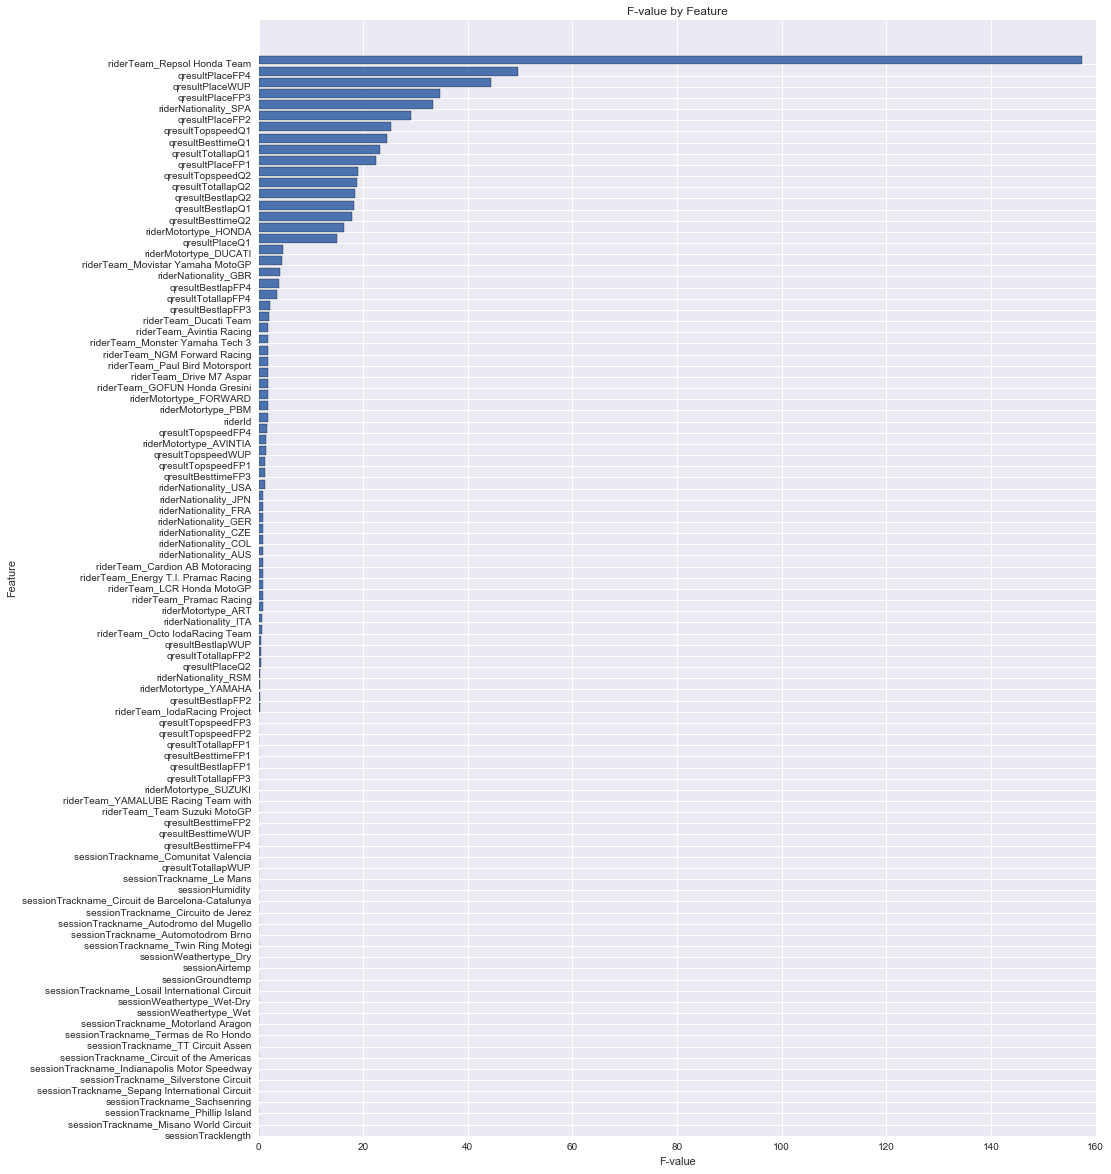

In [24]:
import numpy
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

list_features = df_allfeaturesprocessed.columns

kbsel = SelectKBest(k = 'all', score_func = f_classif).fit(df_allfeaturesprocessed, df_label)

#Create tables for the K-best features Anova F-value.
kbfeat = pandas.DataFrame([list_features, kbsel.scores_]).T
kbfeat.columns = ['Feature', 'Anova F-value']
kbfeat = kbfeat.sort(['Anova F-value'], ascending = True).reset_index(drop = True)

#Generate vertical bar chart
y = kbfeat['Feature']
y_pos = numpy.arange(len(y))
x = kbfeat['Anova F-value']

fig = plt.figure(figsize=(15, 20));
plt.barh(y_pos, x)
plt.yticks(y_pos, y)
plt.title("F-value by Feature")
plt.xlabel("F-value")
plt.ylabel("Feature")

Clearly, the impressive results set by Marc Marquez over the 2014 season are showing their influence on deciding the optimal feature selection. Marc Marquez belongs to the 'Repsol Honda' team, is Spanish ('SPA') and rides a bike manufactured by 'Honda'. Dummy features for each of these variables appear in the top 15 F-value features above. 

However, to ensure the model is able to generalize well, the above optimal feature list was used as a guide rather than being used to determine the final feature list. The final feature list for the predictive model is shown below.

In [25]:
import numpy

list_finalfeats = numpy.array(["qresultPlaceFP1",
                               "qresultPlaceFP2",
                               "qresultPlaceFP3",
                               "qresultPlaceFP4",
                               "qresultPlaceQ1",
                               "qresultPlaceQ2",
                               "qresultPlaceWUP",
                               "qresultBestlapQ1",
                               "qresultBestlapQ2",
                               "qresultTopspeedQ1",
                               "qresultTopspeedQ2",
                               "riderId",
                               "riderTeam_Avintia Racing",
                               "riderTeam_Cardion AB Motoracing",
                               "riderTeam_Drive M7 Aspar",
                               "riderTeam_Ducati Team",
                               "riderTeam_Energy T.I. Pramac Racing",
                               "riderTeam_GOFUN Honda Gresini",
                               "riderTeam_IodaRacing Project",
                               "riderTeam_LCR Honda MotoGP",
                               "riderTeam_Monster Yamaha Tech 3",
                               "riderTeam_Movistar Yamaha MotoGP",
                               "riderTeam_NGM Forward Racing",
                               "riderTeam_Octo IodaRacing Team",
                               "riderTeam_Paul Bird Motorsport",
                               "riderTeam_Pramac Racing",
                               "riderTeam_Repsol Honda Team",
                               "riderTeam_Team Suzuki MotoGP",
                               "riderTeam_YAMALUBE Racing Team with"])

df_finalfeatures = df_allfeaturesprocessed[list_finalfeats]
print(df_finalfeatures.columns)

Index(['qresultPlaceFP1', 'qresultPlaceFP2', 'qresultPlaceFP3',
       'qresultPlaceFP4', 'qresultPlaceQ1', 'qresultPlaceQ2',
       'qresultPlaceWUP', 'qresultBestlapQ1', 'qresultBestlapQ2',
       'qresultTopspeedQ1', 'qresultTopspeedQ2', 'riderId',
       'riderTeam_Avintia Racing', 'riderTeam_Cardion AB Motoracing',
       'riderTeam_Drive M7 Aspar', 'riderTeam_Ducati Team',
       'riderTeam_Energy T.I. Pramac Racing', 'riderTeam_GOFUN Honda Gresini',
       'riderTeam_IodaRacing Project', 'riderTeam_LCR Honda MotoGP',
       'riderTeam_Monster Yamaha Tech 3', 'riderTeam_Movistar Yamaha MotoGP',
       'riderTeam_NGM Forward Racing', 'riderTeam_Octo IodaRacing Team',
       'riderTeam_Paul Bird Motorsport', 'riderTeam_Pramac Racing',
       'riderTeam_Repsol Honda Team', 'riderTeam_Team Suzuki MotoGP',
       'riderTeam_YAMALUBE Racing Team with'],
      dtype='object')


####Estimation

In order to select the optimal set of estimation algorithm for the final predictive model, a GridSearchCV Pipeline was conducted. According to the sklearn documentation, GridSearchCV implements a 'fit' and 'predict' method like any classifier except that the parameters of the classifier used to predict are optimized by cross-validation.

For this analysis, a collection of pre-processors and estimators were added to a list which was passed to the GridSearchCV. Pre-processors and estimators included within the list and their parameter optimization ranges are noted below.

Pre-processors:

- SelectKBest(

          'k':[2, 4, 6, 8, 10, 12, 14, 16, 'all']

    )

Estimators:

- GaussianNB()

- SVC(

          'kernel': ["poly", "rbf"],
          'C':[0.05, 0.025, 0.5, 1, 10, 10^2],
          'tol':[10^-1, 10^-2, 10^-4, 10^-8],
          'class_weight':['auto']

    )
    
- DecisionTreeClassifier(

                      'criterion':['gini', 'entropy'],
                      'splitter':['random', 'best'],
                      'max_depth':[None, 2, 4, 6, 8, 10, 15, 20]

    )
    
- RandomForestClassifier(

                      'n_estimators':[5, 10, 15, 20],
                      'min_samples_split':[2, 3, 4, 5],
                      'random_state':[42]

    )
    
- LogisticRegression(

                  'C':[0.05, 0.025, 0.5, 1, 10, 10^2, 10^4, 10^8],
                  'tol':[10^-1, 10^-2, 10^-4, 10^-8],
                  'class_weight':['auto']

    )

Tuning parameters allows the user to optimize the models performance over desired performance criteria. For example, a certain set of parameters may allow more information to be extracted from a given set of features (varying validation scores as a result) while another set may allow for lower amount of computational processing. In this case GridSearchCV has been set to optimize parameter selection against the F1 score.

In [26]:
#GridSearchCV estimation library
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import f_classif
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.svm import SVR
from sklearn.svm import LinearSVR
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline


def build_clf_list(clf_select):
    ref_list = []
    clf_list = []
    param_list = []

    if 1 in clf_select:
        ref = "minmax"
        clf = "MinMaxScaler()"
        param = {}
        ref_list.append(ref)
        clf_list.append(clf)
        param_list.append(param)
    
    if 2 in clf_select:
        ref = "skb"
        clf = "SelectKBest()"
        param = {"k":["all"]}
        ref_list.append(ref)
        clf_list.append(clf)
        param_list.append(param)
    
    if 3 in clf_select:
        ref = "knn"
        clf = "KNeighborsClassifier()"
        param = {}
        ref_list.append(ref)
        clf_list.append(clf)
        param_list.append(param)
    
    if 4 in clf_select:
        ref = "naive"
        clf = "GaussianNB()"
        param = {}
        ref_list.append(ref)
        clf_list.append(clf)
        param_list.append(param)
        
    if 5 in clf_select:
        ref = "svc"
        clf = "SVC()"
        param = {"kernel": ["poly", "rbf"],
                 "C": [0.05, 0.025, 0.5, 1, 10, 10**2],
                 "gamma": [0.0, 0.001, 0.0001, "auto"],
                 "class_weight":["balanced"]}
        ref_list.append(ref)
        clf_list.append(clf)
        param_list.append(param)
        
    if 6 in clf_select:
        ref = "linsvc"
        clf = "LinearSVC()"
        param = {"C":[0.05, 0.025, 0.5, 1, 10, 10**2],
                 "tol":[10**-1, 10**-2, 10**-4, 10**-8],
                 "class_weight":["balanced"]}
        ref_list.append(ref)
        clf_list.append(clf)
        param_list.append(param)

    if 7 in clf_select:
        ref = "svr"
        clf = "LinearSVR()"
        param = {}
        ref_list.append(ref)
        clf_list.append(clf)
        param_list.append(param)
        
    if 8 in clf_select:
        ref = "linsvr"
        clf = "LinearSVR()"
        param = {}
        ref_list.append(ref)
        clf_list.append(clf)
        param_list.append(param)
        
    if 9 in clf_select:
        ref = "dt"
        clf = "DecisionTreeClassifier()"
        param = {"criterion":["gini", "entropy"],
                 "splitter":["random", "best"],
                 "max_depth":[None, 2, 4, 6, 8, 10, 15, 20]}
        ref_list.append(ref)
        clf_list.append(clf)
        param_list.append(param)

    if 10 in clf_select:
        ref = "rf"
        clf = "RandomForestClassifier()"
        param = {"n_estimators":[5, 10, 15, 20],
                 "min_samples_split":[2, 3, 4, 5],
                 "random_state":[42]}
        ref_list.append(ref)
        clf_list.append(clf)
        param_list.append(param)

    if 11 in clf_select:
        ref = "lr"
        clf = "LogisticRegression()"
        param = {"C":[0.05, 0.025, 0.5, 1, 10, 10**2],
                 "tol":[10**-1, 10**-2, 10**-4, 10**-8],
                 "class_weight":["auto"]}
        ref_list.append(ref)
        clf_list.append(clf)
        param_list.append(param)
    
    if 12 in clf_select:
        ref = "pca"
        clf = "PCA()"
        param = {"n_components":[1, 2, 3, 4, 5],
                 "whiten":[True, False]}
        ref_list.append(ref)
        clf_list.append(clf)
        param_list.append(param)
    
    return ref_list, clf_list, param_list


def build_pipe(ref, clf, param):
    pipe_ref = []
    pipe_param = {}
    
    pipe_ref.append([ref, eval(clf)])
    
    for key, value in param.items():
        pipe_param[ref + "__" + key] = value
    
    return pipe_ref, pipe_param


def build_pipe_list(ref_list, clf_list, param_list):
    import itertools
    
    pipe_ref_list = []
    pipe_param_list = {}
    
    for ref, clf, param in zip(ref_list, clf_list, param_list):
        pipe_ref, pipe_param = build_pipe(ref, clf, param)
        
        pipe_ref_list.append([pipe_ref[0][0], pipe_ref[0][1]]) 
        pipe_param_list.update(pipe_param) 
    
    return pipe_ref_list, pipe_param_list


def optim_clf(clf, param, cv, feat, label):
    from sklearn.grid_search import GridSearchCV
    from sklearn.metrics import make_scorer
    from sklearn.metrics import f1_score
    
    f1score = make_scorer(f1_score)
    
    clf = GridSearchCV(clf, param, scoring = f1score, cv = cv)
    clf = clf.fit(feat, label)
    
    return clf.best_estimator_


def optim_clf_list(clf_list, param_list, cv, feat, label):
    import itertools
    
    clf_list_bestest = []
    
    for clf, param in zip(clf_list, param_list):
        clf.best_estimator_ = optim_clf(clf, param, cv, feat, label)
        clf_list_bestest.append(clf.best_estimator_) 
    
    return clf_list_bestest


def eval_clf(clf, feat, label): 
    from sklearn.metrics import f1_score
    from sklearn.metrics import recall_score
    from sklearn.metrics import precision_score
    
    label_pred = clf.predict(feat) 
    
    f1score = f1_score(label, label_pred) 
    recall = recall_score(label, label_pred) 
    precision = precision_score(label, label_pred) 
    
    return f1score, recall, precision


def eval_clf_list(clf_list, feat, label): 
    clf_list_score = []
    
    for clf in clf_list: 
        f1score, recall, precision = eval_clf(clf, feat, label)
        clf_list_score.append([f1score, recall, precision]) 
    
    return clf_list_score

Tested pipelines are shown in the following section. Each combination involved the use of SelectKBest based on an ANOVA F-value to prioritize the passed-through features.

####Validation

Validation involves separating a dataset into two subsets of data, one for training and the other for testing. This allows you to train a prediction model on a training dataset and test the same model specification on a separate/independent dataset. This practice minimizes the potential for the model to overfit the data, which would translate into good in-sample performance, but poor out-of-sample performance. For this assessment, each of the various combinations of estimators were trained/tested against a cross-validation loop (StratifiedShuffleSplit) as part of the pipeline search. The optimal pipeline, associated parameters and validation metrics are shown below.

In [30]:
from sklearn.pipeline import Pipeline
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.grid_search import GridSearchCV

X_all = df_allfeaturesprocessed[list_finalfeats]
y_all = df_label

#clf_select = [2,4] #F1 Score: 0.409090909091 Recall: 1.0 Precision: 0.257142857143
#clf_select = [2,5] #F1 Score: 0.787878787879 Recall: 0.722222222222 Precision: 0.866666666667
#clf_select = [2,9] #F1 Score: 0.777777777778 Recall: 0.777777777778 Precision: 0.777777777778
clf_select = [2,10] #F1 Score: 0.941176470588 Recall: 0.888888888889 Precision: 1.0
#clf_select = [2,11] #F1 Score: 0.631578947368 Recall: 1.0 Precision: 0.461538461538

ref_list, clf_list, param_list = build_clf_list(clf_select)

#pipe_ref, pipe_param = build_pipe(ref, clf, param)
pipe_ref_list, pipe_param_list = build_pipe_list(ref_list, clf_list, param_list)

pipe = Pipeline(pipe_ref_list)
param = pipe_param_list

cv = StratifiedShuffleSplit(y_all, test_size = 0.1)
grid_search = GridSearchCV(pipe, param, n_jobs = 1, cv = cv)
grid_search.fit(X_all, y_all)

clf = grid_search.best_estimator_
print(clf)

param_bestest = grid_search.best_params_
print(param_bestest)

f1score, recall, precision = eval_clf(clf, X_all, y_all)
print("F1 Score:", f1score, "Recall:", recall, "Precision:", precision)                                     

Pipeline(steps=[['skb', SelectKBest(k='all', score_func=<function f_classif at 0x0000021AACE58C80>)], ['rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)]])
{'rf__random_state': 42, 'skb__k': 'all', 'rf__n_estimators': 20, 'rf__min_samples_split': 5}
F1 Score: 0.8 Recall: 0.666666666667 Precision: 1.0


Precision can be thought of as the ratio of how often the model is correct in identifying a positive label to the total times it guesses a positive label, while recall can be thought of as the ratio of how often the model correctly identifies a label as positive to how many total positive labels there actually are. In the context of this assessment, it could be argued that precision forms a more important metric than recall.

Below shows the StratifiedShuffleSplit evaluation metrics for each of the evaluated estimators, post GridSearchCV parameter calibration:

- Pipe(SelectKBest, GaussianNB()): F1 Score: 0.409090909091 Recall: 1.0 Precision: 0.257142857143
- Pipe(SelectKBest, SVC()): F1 Score: 0.787878787879 Recall: 0.722222222222 Precision: 0.866666666667
- Pipe(SelectKBest, DecisionTreeClassifier()): F1 Score: 0.777777777778 Recall: 0.777777777778 Precision: 0.777777777778
- Pipe(SelectKBest, RandomForestClassifier()): F1 Score: 0.8 Recall: 0.666666666667 Precision: 1.0
- Pipe(SelectKBest, LogisticRegression()): F1 Score: 0.631578947368 Recall: 1.0 Precision: 0.461538461538

The results suggest a trade-off between precision and recall which must be balanced according to the desired priority evaluation metric. Of the above, the RandomForestClassifier was ultimately selected due to its more favourable precision score.